# **Few-Shots Learning with Prototypical Networks**

## Apprentissage profond et traitement du signal - MVA 

### Auteurs: Naïl Khelifa et Quentin Moayedpour

#### Chargement des librairies

In [18]:
## classique 

import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import torch
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os

## handmade
import src.train as train
import src.test_model as test
from src.proto_encoder import PrototypeEncoder
from src.viz import viz_tsne, plot_from_list_acc
from src.test_model import eval_n_shot
from src.matching import MatchingNetwork

# Sommaire

1. [Exploration des données](#présentation-des-données)  
   - [1.1 Données d'entraînement](#11-donnees-entrainement)   
   - [1.2 Données d'enrôlement](#12-donnees-enrolement)
   - [1.3 Données de test d'apprentissage frugal](#12-donnees-frugale)   
2. [Few-Shot Learning](#fewshotlearning) 
3. [Prototypical Neural Networks](#méthode-a)  
   - [3.1 Description](#31-description)  
   - [3.2 Entraînement de l'encodeur](#32-encodeur)  
   - [3.3 Visualisation de l'espace latent](#33-espace-latent)  
   - [3.4 Performance selon l'entraînement](#32-perf-entrainement)
      -[Poorly trained model](#poorly)
      -[Model trained on few epochs](#few-epochs)
      -[Large number of epochs](#lots-of-epochs)
      -[Selon le nombre de données d'entraînement](#training-amount)
4. [Matching Networks](#matching)  
   - [5.1 Description](#51-description)  
   - [5.2 Implémentation](#52-implémentation)  
   - [5.3 Résultats obtenus](#53-résultats-obtenus)  
6. [Comparaison des méthodes](#comparaison-des-méthodes)  
   - [6.1 Analyse des performances](#61-analyse-des-performances)  
   - [6.2 Résultats finaux](#62-résultats-finaux)  
7. [Limites et perspectives](#limites-et-perspectives)  
   - [7.1 Limites identifiées](#71-limites-identifiées)  
   - [7.2 Améliorations possibles](#72-améliorations-possibles)  
8. [Conclusion](#conclusion)  


## 1. **Exploration des données** 

### 1.1. Données d'entraînement

On rappelle brièvement le contexte du jeu de donnée d'entraînement, donné en TP3. 

In [19]:
data_path = os.path.dirname(os.getcwd())
path = os.path.join(data_path,'data/train.hdf5')
data_train = h5py.File(path , 'r')

signals_train = np.array(data_train['signaux'])
snr_train =  np.array(data_train['snr'])
labels_id_train = np.array(data_train['labels'])

data_train.close()

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

In [20]:
signals_train[0].shape

(2048, 2)

L'émetteur peut provenir de 6 catégories différentes (différenciées selon différents paramètres) correspondant à des classes dont le labels varie de 0 à 6.

In [21]:
np.unique(labels_id_train)

array([0, 1, 2, 3, 4, 5], dtype=int8)

Les 6 classes sont relativement équilibrées, pas de problème jusque là.

In [22]:
# Étude de la répartition des classes
unique_classes, class_counts = np.unique(labels_id_train, return_counts=True)
total_signaux = len(labels_id_train)
class_percentages = (class_counts / total_signaux) * 100
# Affichage des résultats
print("Répartition des classes :")
for cls, count, pct in zip(unique_classes, class_counts, class_percentages):
    print(f"Classe {cls} : {count} signaux | {pct:.2f}% du total")

Répartition des classes :
Classe 0 : 5143 signaux | 17.14% du total
Classe 1 : 4968 signaux | 16.56% du total
Classe 2 : 5053 signaux | 16.84% du total
Classe 3 : 4867 signaux | 16.22% du total
Classe 4 : 4894 signaux | 16.31% du total
Classe 5 : 5075 signaux | 16.92% du total


### 1.2. Données d'enrôlement

In [23]:
data_path = os.path.dirname(os.getcwd())
path = os.path.join(data_path,'data/enroll.hdf5')
data_enroll = h5py.File(path , 'r')

signals_enroll = np.array(data_enroll['signaux'])
snr_enroll =  np.array(data_enroll['snr'])
labels_id_enroll = np.array(data_enroll['labels'])

data_enroll.close()

Le contexte est le même, les signaux ont le même format. La seule différence réside dans leur label. Nous allons voir dans la partie suivante (quand nous rappellerons le concept de few-shot learning) pourquoi ceci est important. 

Pour l'instant, on s'intéresse à ce qui sera important par la suite: aux classes des signaux d'enrôlement.

In [24]:
np.unique(labels_id_enroll)

array([ 6,  7,  8,  9, 10, 11], dtype=int8)

Ce qui est remarquable c'est que *les labels de ses classes diffèrent complètement de ceux des classes des données d'entraînement*. C'est ce cadre qui justifie l'approche par **apprentissage frugal**.

In [25]:
# Étude de la répartition des classes
unique_classes, class_counts = np.unique(labels_id_enroll, return_counts=True)
total_signaux = len(labels_id_enroll)
class_percentages = (class_counts / total_signaux) * 100
# Affichage des résultats
print("Répartition des classes :")
for cls, count, pct in zip(unique_classes, class_counts, class_percentages):
    print(f"Classe {cls} : {count} signaux | {pct:.2f}% du total")

Répartition des classes :
Classe 6 : 93 signaux | 18.60% du total
Classe 7 : 99 signaux | 19.80% du total
Classe 8 : 78 signaux | 15.60% du total
Classe 9 : 66 signaux | 13.20% du total
Classe 10 : 75 signaux | 15.00% du total
Classe 11 : 89 signaux | 17.80% du total


Deux remarques fondamentales pour la suite: 

1. Les classes sont à peu près **équilibrées** et disponibles en **bien moins grand nombre** que les données d'entraînement. Pourtant, comme nous allons le voir dans le dataset de test, ce sont ces données qui sont importantes car elles partagent les même labels que l'ensemble de test sur lequel on souhaite faire nos prédictions. 

2. Comme il a été précisé dans la consigne du projet, **les données de enrôlement sont relativement généreuses** et il sera intéressant de voir comment performent les modèles selon le nombre de signaux d'enrôlement qui sont utilisées pour enrôler  chacune de ces classes.

### 1.3. Données de test d'apprentissage frugal

In [26]:
data_path = os.path.dirname(os.getcwd())
path = os.path.join(data_path,'data/test_fewshot.hdf5')
data_fs = h5py.File(path , 'r')

signals_fs = np.array(data_fs['signaux'])
snr_fs =  np.array(data_fs['snr'])
labels_id_fs = np.array(data_fs['labels'])

data_fs.close()

Cette base de données fournit les signaux qui seront utilisés comme test pour évaluer la performance des modèles d'apprentissage frugal. 

In [27]:
np.unique(labels_id_fs)

array([ 6,  7,  8,  9, 10, 11], dtype=int8)

Les signaux de test ont des labels qui correspondent bien à ceux des classes enrôlées. 

In [28]:
# Étude de la répartition des classes
unique_classes, class_counts = np.unique(labels_id_fs, return_counts=True)
total_signaux = len(labels_id_fs)
class_percentages = (class_counts / total_signaux) * 100
# Affichage des résultats
print("Répartition des classes :")
for cls, count, pct in zip(unique_classes, class_counts, class_percentages):
    print(f"Classe {cls} : {count} signaux | {pct:.2f}% du total")

Répartition des classes :
Classe 6 : 90 signaux | 18.00% du total
Classe 7 : 74 signaux | 14.80% du total
Classe 8 : 77 signaux | 15.40% du total
Classe 9 : 89 signaux | 17.80% du total
Classe 10 : 83 signaux | 16.60% du total
Classe 11 : 87 signaux | 17.40% du total


Mantenant que nous avons regardé la composition des classes dans les différents dataset, **il convient de justifier pourquoi l'approche par apprentissage frugal s'impose ici**. 

## 2. **Few-Shot Learning**

### 2.1. Cadre général

Le **Few-Shot Learning (FSL)** est une technique de machine learning permettant à un modèle d'apprendre à partir de très peu d'exemples annotés. 

Formellement, 
- L'ensemble de données est $\mathcal{D}=\{(x_1, y_1), \dots, (x_N, y_N)\} $, où chaque $ x_i \in \mathbb{R}^D $ est le vecteur de caractéristiques de dimension $ D $ d'un exemple et $ y_i \in \{1, \dots, K\} $ est le label correspondant. 
- $ S_k $ désigne l'ensemble des exemples de label $ k $.  

L'objectif est de déduire un classificateur $f : \mathbb{R}^D \rightarrow \{1, \cdots, K\}$, capable de prédire les labels $y$ pour des exemples non vus, en s'appuyant sur $(x_{1, k}, k), \cdots, (x_{N,k}, k)$ avec $k = 1, \cdots, K$.

##### *Pourquoi le Few-Shot Learning est adapté dans notre cas ?*

- **Faible disponibilité des données annotées** : Ici, on voit que l'on dispose "que de" environ 90 observations par classe de l'ensemble de test. C'est relativement peu, mais cela reste beaucoup et il ne tient qu'à nous, comme nous le ferons, de n'en retenir que $n=1, 2, 5...$ et on sera dans le cas du **$n$-shot learning**.

- Le cas extrême, appelé **One-Shot Learning**, le modèle doit apprendre à classer correctement à partir d'un seul exemple par classe ($n = 1$). 


#### *Approches Principales*
1. Entraîner un modèle à apprendre à apprendre.
2. Comparer de nouveaux exemples avec ceux appris.
3. Utiliser des modèles pré-entraînés sur des grandes bases de données. (Très utilisé en CV en prenant un backbone type ImageNet)
4. Générer artificiellement plus d'exemples.

Dans ce projet, nous allons revoir et nous concentrer sur deux architectures conçues dans le cadre du FSL et que nous avons vue dans le cadre du cours: 
- le modèle des prototypical networks, au coeur de notre travail
- le modèle des matching networks, qui a attiré notre curiosité car mentionné dans le cours 

Nous comparons dans ce travail ces deux architectures. Avant de passer à l'explication de ces modèles, nous introduisons un peu de vocabulaire. 

#### *Vocabulaire*

* **In-sample data**: Données qui ont été vus par le modèle pendant l'entraînement. De manière plus général on appellera In-sample data les données d'une distribution qui a été vu par le modèle pendant l'entraînement (dans notre cas, les classes 0, 1, 2.. 5)
* **Out-of-sample data**: Inversement, données qui n'ont pas été vus par le modèle pendant l'entraînement (classes 6, 7.. 11 )
* **Espace Latent**: De manière générale, on désigne l'espace latent d'un modèle la representation au sein des couches intermédiaires du réseau. Dans notre cas étant donné que le modèle Prototype renvoi une représentation des données, on appelera l'output du réseau l'espace latent.

## 3. **Prototypical Neural Networks**

### 3.1. **Description**

J. Snell et al (2017) proposent un modèle pour le few shot learning qu'on nommera **modèle Prototype**.

#### *Idée générale*

Le modèle Prototype calculent une représentation $ c_k \in \mathbb{R}^M $, ou prototype, de chaque classe via une fonction d'encodage $ f_\phi : \mathbb{R}^D \to \mathbb{R}^M $ avec des paramètres appris $ \phi $. Chaque prototype est le vecteur moyen des points de support encodés appartenant à sa classe :

$$
c_k = \frac{1}{|S_k|} \sum_{(x_i, y_i) \in S_k} f_\phi(x_i) \tag{1}
$$

![Texte alternatif](../fig/shematest.jpeg)

**Choix de la métrique**: Étant donné une fonction de distance $ d : \mathbb{R}^M \times \mathbb{R}^M \to [0, +\infty) $, le modèle produit une distribution sur les classes pour un point de requête $ x $ basée sur un softmax des distances aux prototypes dans l'espace d'encodage :

$$
p_\phi(y = k \mid x) = \frac{\exp(-d(f_\phi(x), c_k))}{\sum_{k'} \exp(-d(f_\phi(x), c_{k'}))} \tag{2}
$$

#### *Training Episodes*

- **Modalité d'entraînement**: L'apprentissage se fait en minimisant la log-probabilité négative $J(\phi) = -\log p_\phi(y = k \mid x)$ de la classe vraie $ k $ . Les épisodes d'entraînement sont formés en sélectionnant aléatoirement un sous-ensemble de classes à partir de l'ensemble d'entraînement, puis en choisissant un sous-ensemble d'exemples au sein de chaque classe pour agir comme ensemble de support et un sous-ensemble du reste pour servir de points de requête.

- **Détail d'un training episode**: il y a trois éléments principaux :

1. **Sélection de classes** :
   - Un sous-ensemble de $ S_k $ classes est sélectionné aléatoirement parmi toutes les classes disponibles dans l'ensemble d'entraînement.

2. **Points de support (support set)** :
   - Pour chaque classe sélectionnée, choisir un nombre de points $x_k$ tel que $y_k \in S_k$. Calculer les $c_k$

3. **Points de requête (query set)** :
   - Sélectionner l'ensemble de requête dont les points sont de classes **différentes** que celles sélectionnées.

4. **Classification des points de requête** :
   - Pour chaque point de requête $ \mathbf{x} \in Q_k $, calculer la probabilité qu'il appartienne à $ k $ en      $ p_\phi(y = k | \mathbf{x})$
     où $ d $ est une fonction de distance (par exemple, la distance euclidienne).

3. **Calcul de la perte** :


     $J(\phi) = -\frac{1}{N_C \cdot N_Q} \sum_{k=1}^{N_C} \sum_{(\mathbf{x}, y) \in Q_k} \log p_\phi(y = k | \mathbf{x})$
   - Actualiser les poids du modèle.

![img](../fig/proto2.png)

Maintenant Passons à l'implémentation !

### 3.2. **Entraînement de l'encodeur**

L'architecture de l'encodeur que nous avons retenu dans ce travail est la suivante : 

---
##### *Structure :*
- **Entrée** : Tenseur de forme `(batch_size, input_channels, signal_length)`.
- **Sortie** : Tenseur d'embeddings de forme `(batch_size, output_dim * reduced_length)`.
- **Blocs Convolutifs** : 
  - Quatre blocs convolutifs, chacun composé de :
    - Une convolution 1D (`kernel_size=5`, `padding=2`).
    - Une normalisation batch (`BatchNorm1d`).
    - Une activation ReLU.
    - Un pooling max (`MaxPool1d`) pour réduire la longueur des signaux.

##### *Résumé du Flux des Données :*
1. Le signal passe par 4 blocs convolutifs successifs.
2. À chaque bloc, les dimensions des canaux augmentent et la longueur des signaux est divisée par 2.
3. La sortie finale est aplatie pour produire un vecteur d'embedding compact.

----

On commence par charger les données d'entraînement, que l'on va plus tard utiliser pour entraîner le modèle de few-shot learning en question. 

In [29]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 2,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 1, # % of data of the train set used for training
}

In [3]:
model, best_acc, train_loss, train_acc = train.main(opt)

=== Epoch: 0 ===


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Avg Train Loss: 1.1144161862134934, Avg Train Acc: 0.4219999985396862
=== Epoch: 1 ===


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

Avg Train Loss: 0.7244796922802925, Avg Train Acc: 0.6192999994754791
Final model saved to ../logs/last_model.pth


### 3.2. **Visualisation de l'espace latent**

$\textcolor{red}{\text{L'objet de cette partie est de "vérifier" l'hypothèse centrale des prototypical networks à l'aide de l'encodeur précédemment entraîné}}$

**Hypothèse**: l'embeddings (représentations) des données, projetées dans l'espace latent par l'encodeur, sont organisées de manière à ce que :

- Les points appartenant à la **même classe** soient regroupés dans une région compacte de l'espace.
- Les points appartenant à des **classes différentes** soient bien séparés.

En d'autres termes, l'espace des embeddings doit être **métriquement structuré**, ce qui signifie que la proximité dans cet espace reflète la **similarité des classes**.


In [30]:
from src.test_model import test_n_shot
from src.viz import plot_from_list_acc

Pour tester cette hypothèse, on considères 4 modèles: 

- 3 modèles entraîné sur $100$ epochs, mais pour lesquels $N_s$ et $N_q$ varie 
- 1 modèle entraîné sur $50$ epochs

| Modèle | $N_s$ | $N_q$ | Epoch |
|--------|-----------|-----------|-------|
| Modèle 1 | 60        | 60        | 100   |
| Modèle 2 | 50        | 50        | 100   |
| Modèle 3 | 100       | 100       | 100   |
| Modèle 4 | 30        | 30        | 50    |

In [7]:
# Instantiate the model
model_1 = PrototypeEncoder()
model_2 = PrototypeEncoder()
model_3 = PrototypeEncoder()
model_4 = PrototypeEncoder()

state_dict_path_1 = os.path.join(os.path.dirname(os.getcwd()), 'logs/last_model_Ns60_Nq60_cl5_ep100.pth')
state_dict_path_2 = os.path.join(os.path.dirname(os.getcwd()), 'logs/last_model_Ns50_Nq50_cl5_ep100.pth')
state_dict_path_3 = os.path.join(os.path.dirname(os.getcwd()), 'logs/last_model_Ns100_Nq100_cl5_ep100.pth')
state_dict_path_4 = os.path.join(os.path.dirname(os.getcwd()), 'logs/last_model_Ns30_Nq30_cl5_ep50.pth')

# ajouter selon cosine

# Step 2: Load the state dictionary
state_dict_1 = torch.load(state_dict_path_1, map_location=torch.device('cpu'))
state_dict_2 = torch.load(state_dict_path_2, map_location=torch.device('cpu'))
state_dict_3 = torch.load(state_dict_path_3, map_location=torch.device('cpu'))
state_dict_4 = torch.load(state_dict_path_4, map_location=torch.device('cpu'))

# Step 3: Load the state dictionary into the model
model_1.load_state_dict(state_dict_1)
model_2.load_state_dict(state_dict_2)
model_3.load_state_dict(state_dict_3)
model_4.load_state_dict(state_dict_4)

# Step 4: Set the model to evaluation mode (optional, for inference)
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()

models = [model_1, model_2, model_3, model_4]

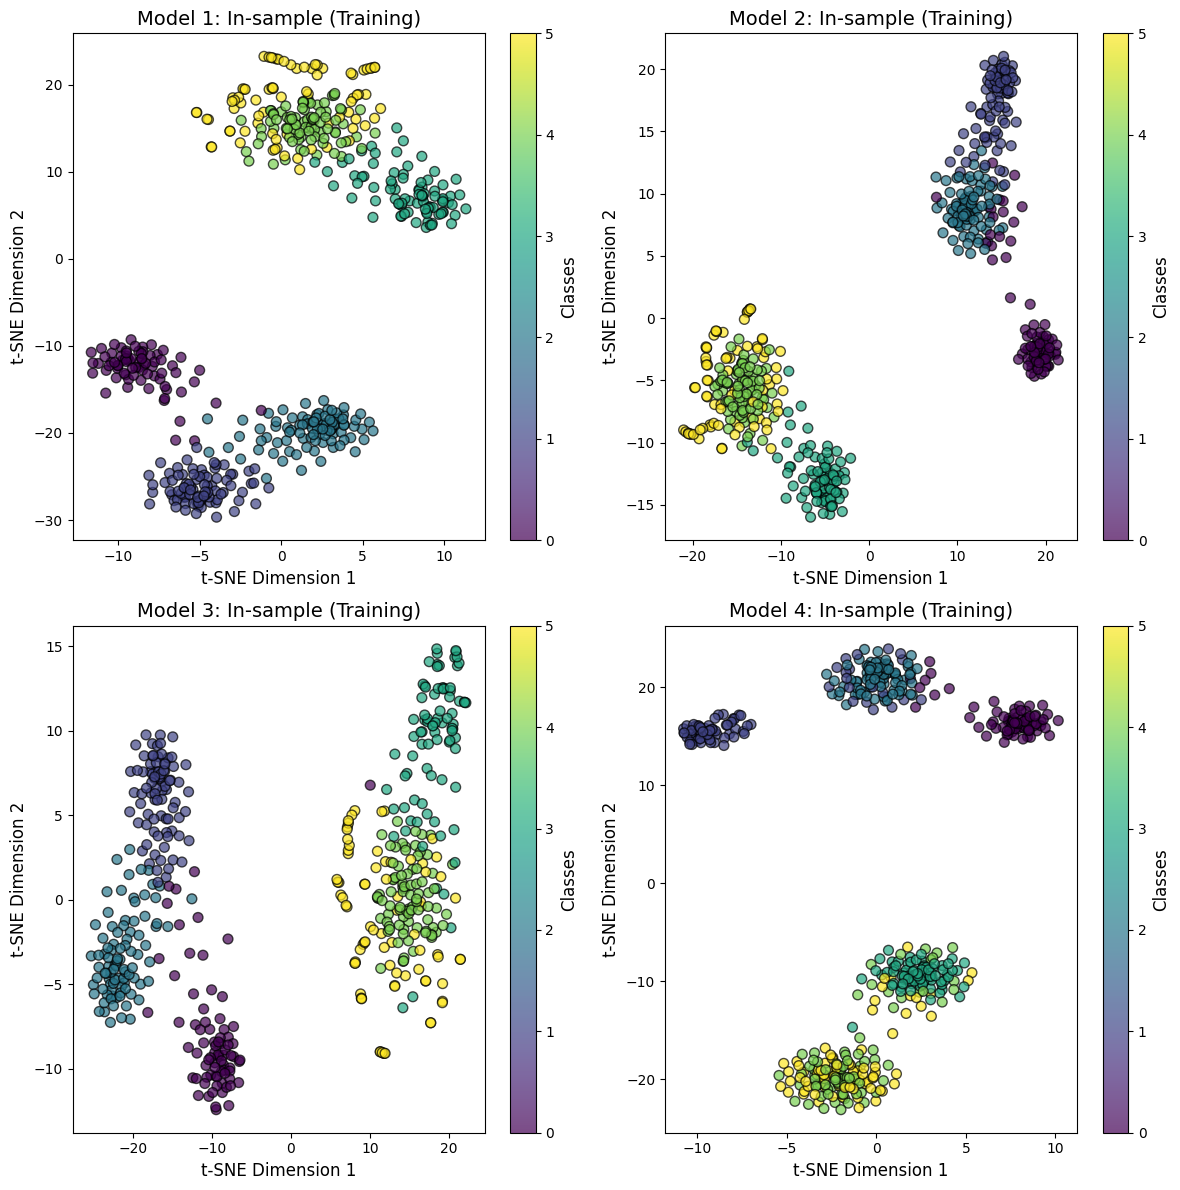

In [6]:
viz_tsne(models, task="train")

| Modèle | $N_s$ | $N_q$ | Epoch |
|--------|-----------|-----------|-------|
| Modèle 1 | 60        | 60        | 100   |
| Modèle 2 | 50        | 50        | 100   |
| Modèle 3 | 100       | 100       | 100   |
| Modèle 4 | 30        | 30        | 50    |

- **Intuition sur la loss**: La minimisation de la Loss amène le modèle à **rapprocher** les points de requête de leur prototype de classe correct et à **éloigner** les points des prototypes des autres classes. En minimisant cette perte, le modèle apprend à **projeter** les points de la même classe près de leur prototype dans l'espace d'embedding, tout en **séparant** les prototypes des différentes classes. Cela permet au modèle de **discriminer** efficacement entre les classes, même avec un nombre très limité d'exemples (few-shot learning).

- **Commentaires**: on voit que 4 classes sont bien distinguées par le modèle, mais que les classes 4 et 5 ne sont pas bien différenciées par le modèle. Il y a trois possibilités: 

1. le modèle n'est pas suffisamment entraîné (c'est pourtant le modèle le plus entraîné ici) et la perte d'entraînement peut encore être réduite. Selon l'intuition précédente, cela signifierait qu'il y a davantage de "discrimination" à apprendre.

2. les classes 4 et 5 sont vraiment difficile à dissocier et l'hypothèse fondamentale des prototypical networks (il existe un embedding où les classes sont regroupées par paquets) est violée. 

3. le choix de nos paramètres lors de l'entraînement ($N_s$ et $N_q$) est mauvais.

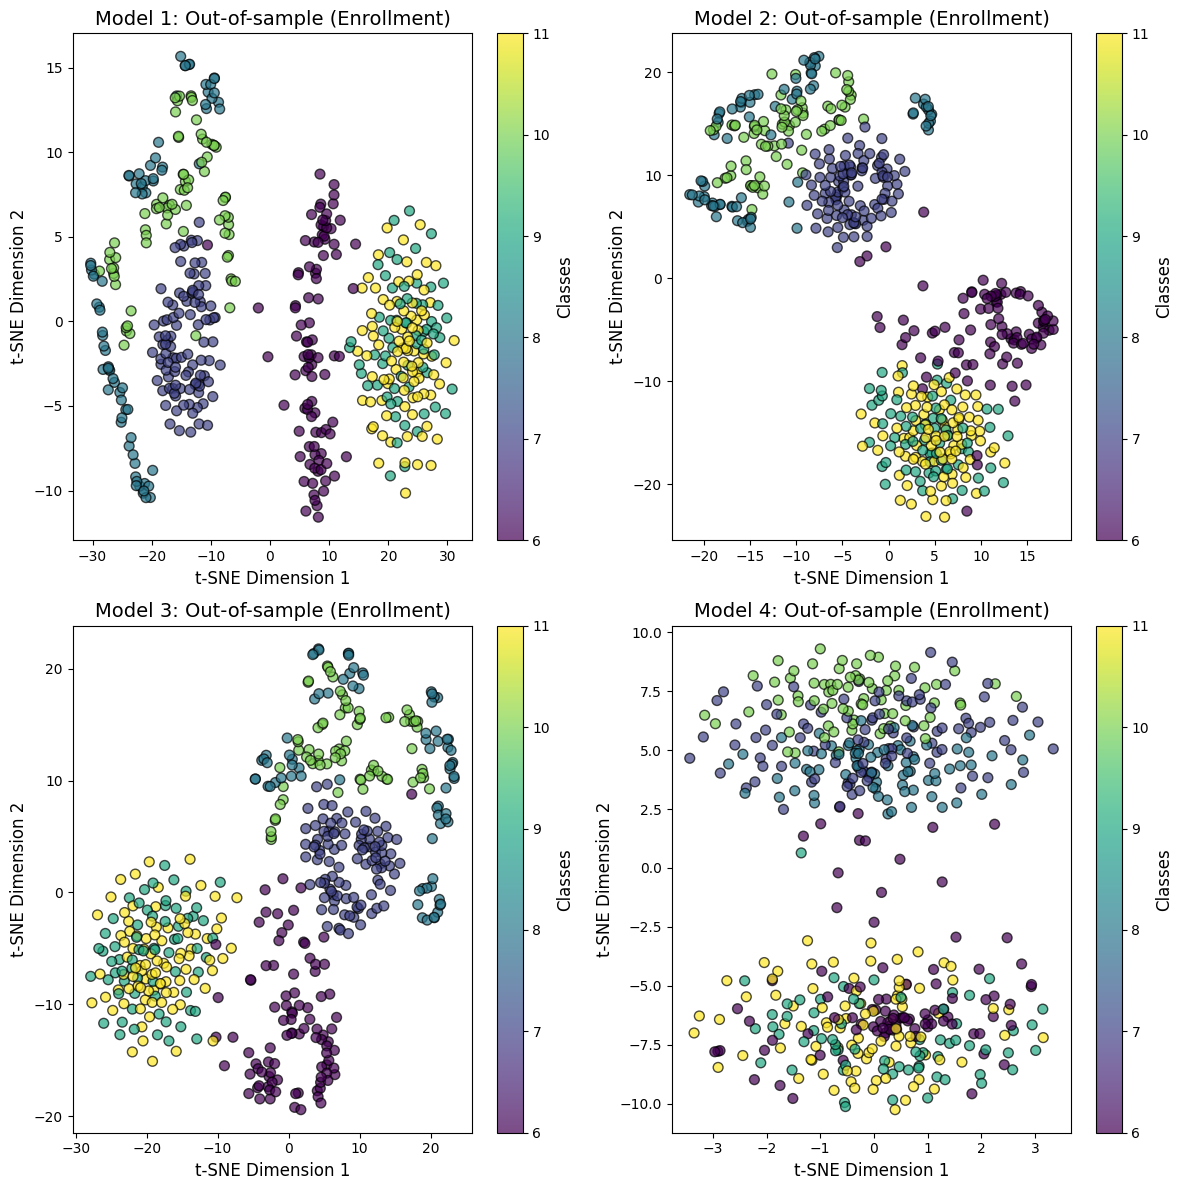

In [8]:
viz_tsne(models, task="enroll")

- On voit que seule la classe 6 est bien séparée.

- Les classes 10, 7 et 8 sont relativement bien séparées.  

- Les classes 9 et 11 sont très mal séparées. 

On a $\texttt{x\_enroll.size() = torch.Size([500, 2, 2048])}$ donc on dispose de 500 échantillons pour enrôler les nouvelles classes. C'est peut-être inutilement grand. On se propose donc d'observer ce qu'il se passe si on réduit l'enrollement lors du calcul des prototypes.

Cette tâche est bien évidemment non triviale, en représentant l'encodage par un modèle non entraîné, on peut voir que les représentations sont réparties presque aléatoirement.

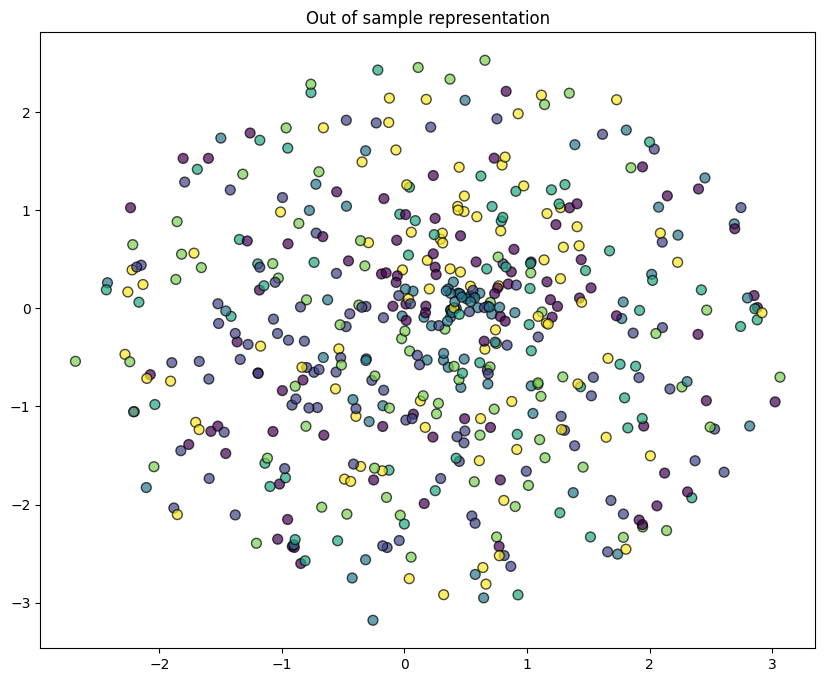

In [33]:
model = PrototypeEncoder()
model.to("cuda:0")
viz_tsne(model, task="enroll")

### 3.4. **Performance selon l'entraînement**

#### *Model Not Trained*

100%|██████████| 9/9 [00:36<00:00,  4.02s/it]


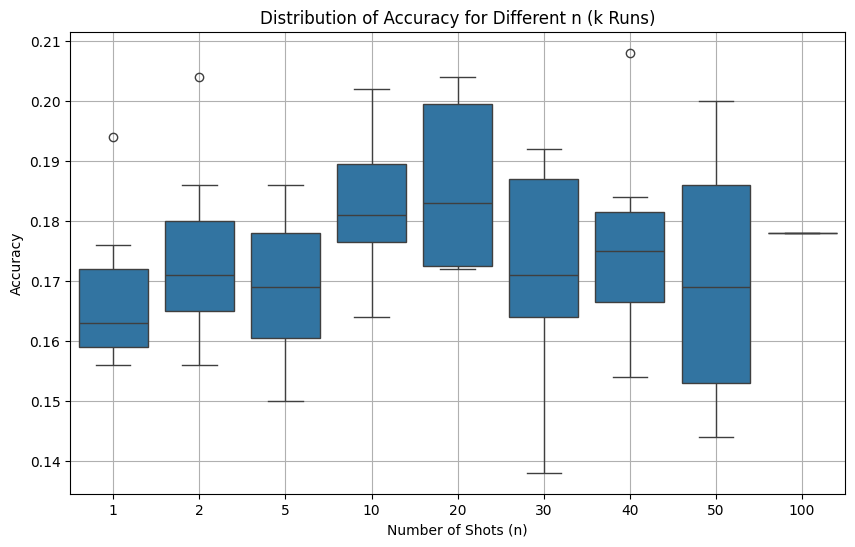

In [10]:
from src.viz import plot_from_list_acc
from src.test_model import test_n_shot

model = PrototypeEncoder()
model = model.to("cuda:0")
list_n = [1, 2, 5, 10, 20, 30, 40, 50, 100]
list_acc = eval_n_shot(model, k=10, list_n=list_n)
plot_from_list_acc(list_acc)

#### *Model trained on few epochs*

In [11]:
model = PrototypeEncoder()

state_dict_path_20 = "./last_model.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_1924/3483792568.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


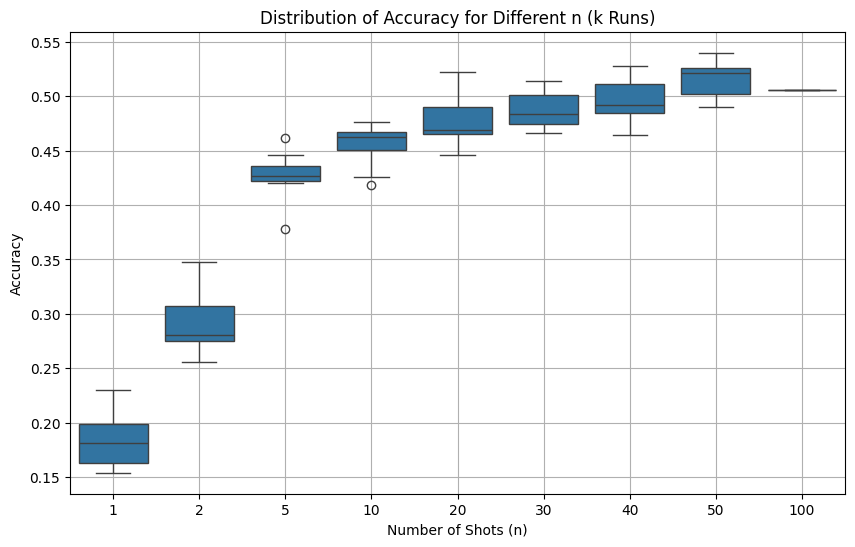

In [12]:
list_acc = eval_n_shot(model, k=10)
plot_from_list_acc(list_acc)

#### *Model trained on a large n of epochs*

In [13]:
model = PrototypeEncoder()

state_dict_path_20 = "../logs/last_model_Ns100_Nq100_cl5_ep100.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_1924/1382448129.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


100%|██████████| 9/9 [00:32<00:00,  3.65s/it]


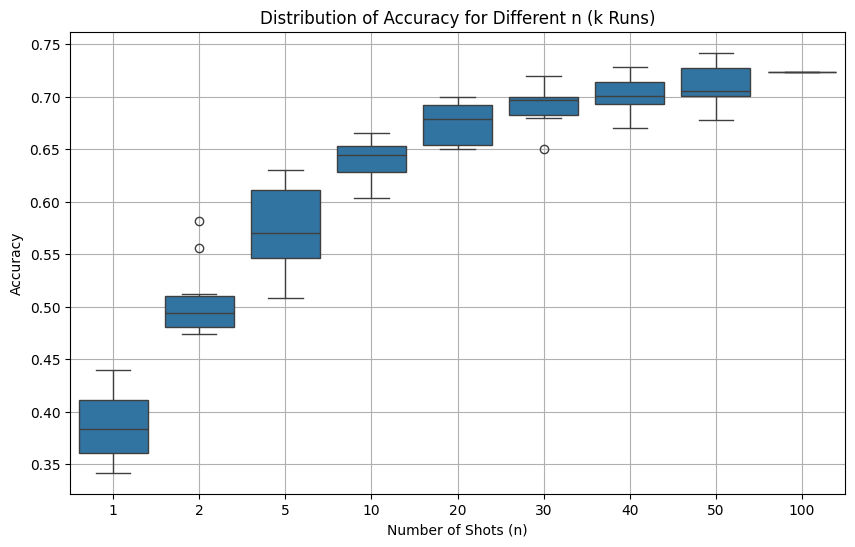

In [14]:
list_acc = eval_n_shot(model, k=10)
plot_from_list_acc(list_acc)

On voit ici que l'entraînement du modèle a un grand impact, les performances sont augmentées en utilisant un modèle qui s'est entraîné plus longtemps.

### Performances en fonction du nombres de données d'entraînement:

In [8]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 0.8, # % of data of the train set used for training
}

In [ ]:
### Ne pas faire tourner (prends du temps)
### Prendre plutot le dictionnaire results.json !!

list_p = [0.05, 0.1, 0.3, 0.5, 1]
results = {}
for p in tqdm(list_p):
    results[p] = {}
    opt["p_data"] = p

    results[p]["model"], _, results[p]["Loss"], results[p]["Accuracy"] = train.main(opt)

    results[p]["perfs"] = eval_n_shot(results[p]["model"], k=10)



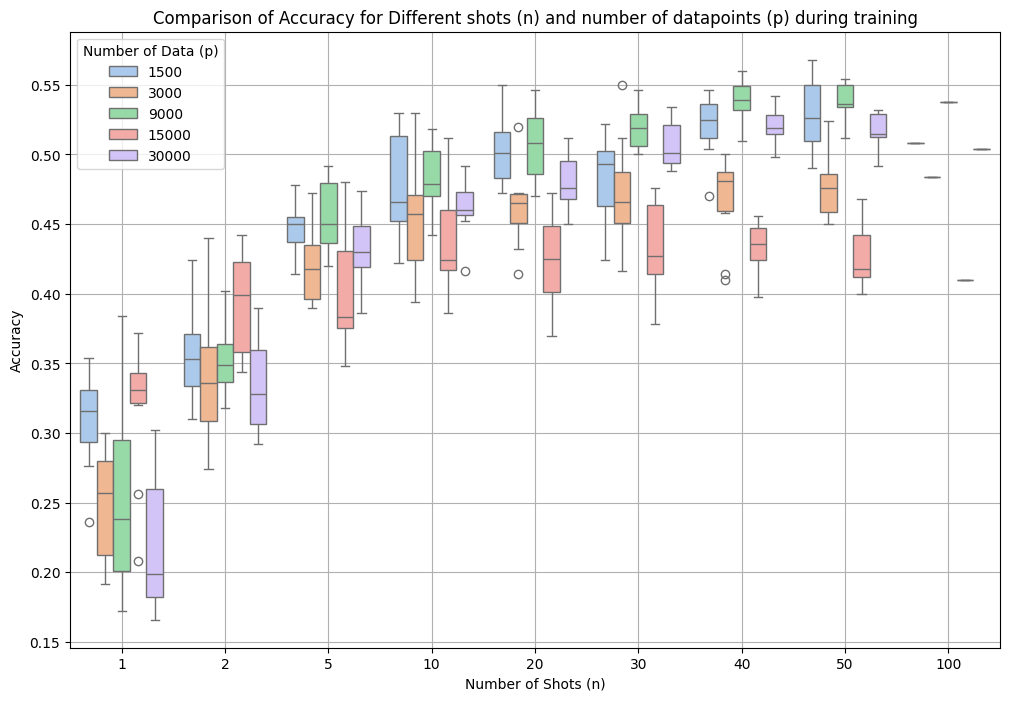

In [ ]:
def plot_from_results(results):

    acc_values = []
    n_labels = []
    p_labels = []
    
    for p, data in results.items():
        list_acc = data["perfs"]
        for n, acc_list in list_acc.items():
            acc_values.extend(acc_list)
            n_labels.extend([n] * len(acc_list))
            p_labels.extend([int(p*30000)] * len(acc_list)) # 30000 correspond a la taille du train

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=n_labels, y=acc_values, hue=p_labels, palette="pastel")
    
    plt.xlabel('Number of Shots (n)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy for Different shots (n) and number of datapoints (p) during training')
    plt.legend(title="Number of Data (p)", loc="best")
    plt.grid(True)

    plt.show()

plot_from_results(results)

Nombre de données ne semble pas être un grand déterminant, on obtient des résultats similaires en utilisant 1500 signaux et 30000 signaux. Un meilleur déterminant devrait être le nombre d'itérations pendant l'entraînement.

In [28]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 0.4, # % of data of the train set used for training
}

In [ ]:
### Ici le nombre d'itération par modèle sera de n_epochs(5) * n_iters

n_iters = [10, 20, 50, 100, 200]
results = {}
for n_iter in tqdm(n_iters):
    results[n_iter] = {}
    opt["iterations"] = n_iter

    results[n_iter]["model"], _, results[n_iter]["Loss"], results[n_iter]["Accuracy"] = train.main(opt)

    results[n_iter]["perfs"] = eval_n_shot(results[n_iter]["model"], k=10)



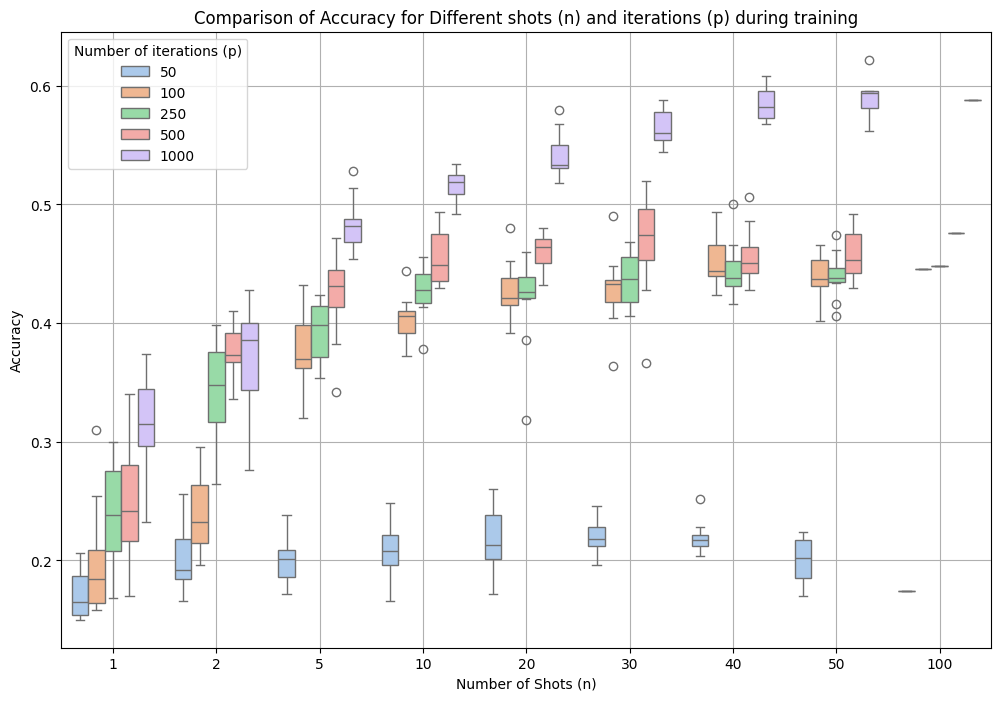

In [32]:
def plot_from_iterations(results):

    acc_values = []
    n_labels = []
    p_labels = []
    
    for p, data in results.items():
        list_acc = data["perfs"]
        for n, acc_list in list_acc.items():
            acc_values.extend(acc_list)
            n_labels.extend([n] * len(acc_list))
            p_labels.extend([int(p*5)] * len(acc_list)) # p*5 pour le nombre d'itération (5= nombre d epochs)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=n_labels, y=acc_values, hue=p_labels, palette="pastel")
    
    plt.xlabel('Number of Shots (n)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy for Different shots (n) and iterations (p) during training')
    plt.legend(title="Number of iterations (p)", loc="best")
    plt.grid(True)

    plt.show()

plot_from_iterations(results)

In [33]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 0.4, # % of data of the train set used for training
}

In [ ]:
### On met le meme nombre pour le support et le query

n_supps = [1, 2, 5, 10, 20, 50]
results = {}
for n_supp in tqdm(n_supps):
    results[n_supp] = {}
    opt["num_support_tr"] = opt["num_query_tr"] = n_supp

    results[n_supp]["model"], _, results[n_supp]["Loss"], results[n_supp]["Accuracy"] = train.main(opt)

    results[n_supp]["perfs"] = eval_n_shot(results[n_supp]["model"], k=10)



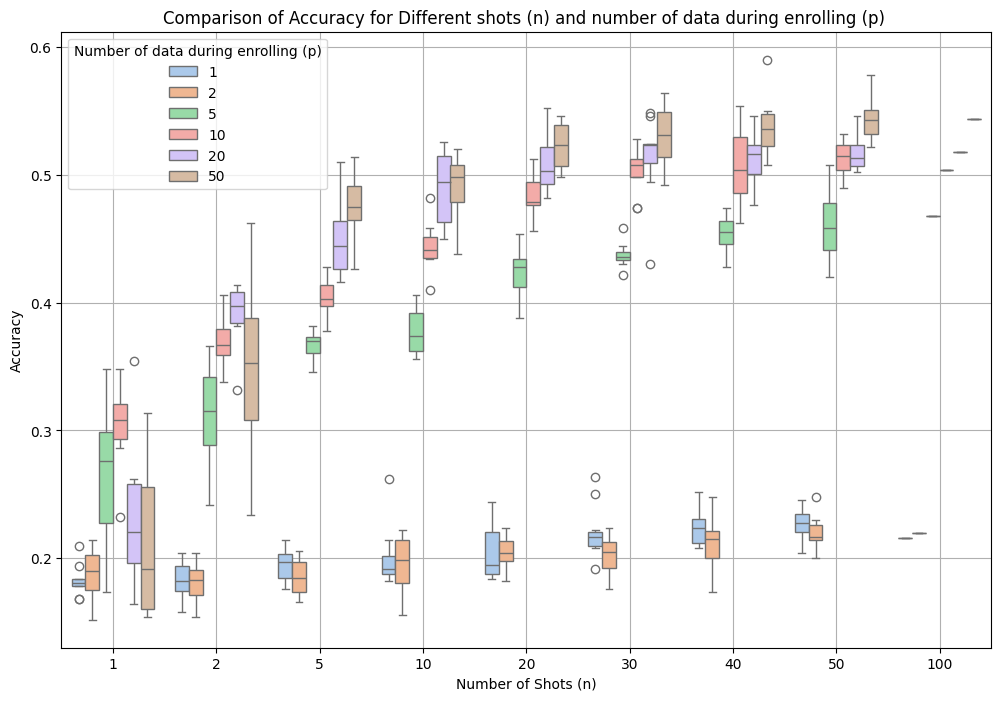

In [35]:
def plot_from_enroll(results):

    acc_values = []
    n_labels = []
    p_labels = []
    
    for p, data in results.items():
        list_acc = data["perfs"]
        for n, acc_list in list_acc.items():
            acc_values.extend(acc_list)
            n_labels.extend([n] * len(acc_list))
            p_labels.extend([int(p)] * len(acc_list)) # 

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=n_labels, y=acc_values, hue=p_labels, palette="pastel")
    
    plt.xlabel('Number of Shots (n)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy for Different shots (n) and number of data during enrolling (p) ')
    plt.legend(title="Number of data during enrolling (p)", loc="best")
    plt.grid(True)

    plt.show()

plot_from_enroll(results)

On teste maintenant sur un plus gros modèle

In [3]:
model = PrototypeEncoder()

state_dict_path_20 = "../logs/last_model_Ns100_Nq100_cl5_ep100.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_2116/1382448129.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


In [4]:
list_res = eval_n_shot(model, k=20)

100%|██████████| 9/9 [00:51<00:00,  5.72s/it]


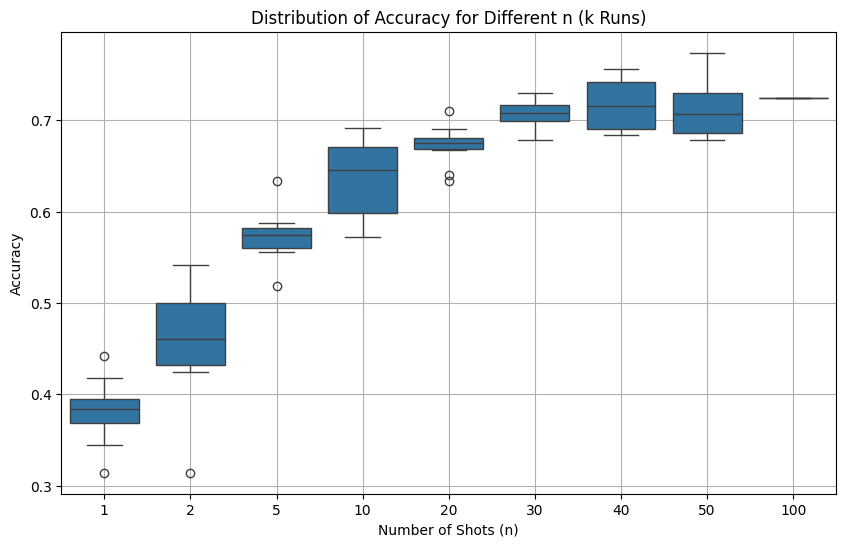

In [5]:
plot_from_list_acc(list_res)

### 3.5 **Que se passe-t-il si l'on change de métrique initiale ?**

L'alternative que l'on a considéré est celle d'utiliser la distance cosinus pour obtenir l'embedding. On a rappelle la définition de cette métrique. 

La **distance cosinus** est une mesure de dissimilarité entre deux vecteurs $x$ et $y$ de dimension $D$ basée sur l'**angle** entre eux et est définie par

$$
\text{cosine\_distance}(x, y) = 1 - \cos(\theta)
$$

où :

$$
\cos(\theta) = \frac{x \cdot y}{\|x\| \|y\|}
$$

- $x \cdot y$ est le produit scalaire des vecteurs $x$ et $y$.
- $\|x\|$ et $\|y\|$ sont les normes euclidiennes des vecteurs $x$ et $y$ :
  $$
  \|x\| = \sqrt{\sum_{i=1}^d x_i^2}
  $$

Cette mesure est souvent utilisée dans des contextes où seules les relations angulaires importent, comme dans l'analyse d'embeddings ou des représentations de texte.


##### *D'abord au niveau de l'espace latent*

In [9]:
# Instantiate the model
model_cosine = PrototypeEncoder()
model_euclidean = PrototypeEncoder()

state_dict_path_cosine = os.path.join(os.path.dirname(os.getcwd()), 'logs/last_model_Ns20_Nq20_cl5_ep50_cosine.pth')
state_dict_path_euclidean = os.path.join(os.path.dirname(os.getcwd()), 'logs/last_model_Ns20_Nq20_cl5_ep50.pth')


# ajouter selon cosine

# Step 2: Load the state dictionary
state_dict_cosine = torch.load(state_dict_path_cosine, map_location=torch.device('cpu'))
state_dict_euclidean = torch.load(state_dict_path_euclidean, map_location=torch.device('cpu'))

# Step 3: Load the state dictionary into the model
model_cosine.load_state_dict(state_dict_cosine)
model_euclidean.load_state_dict(state_dict_euclidean)

# Step 4: Set the model to evaluation mode (optional, for inference)
model_cosine.eval()
model_euclidean.eval()

models = [model_cosine, model_euclidean]

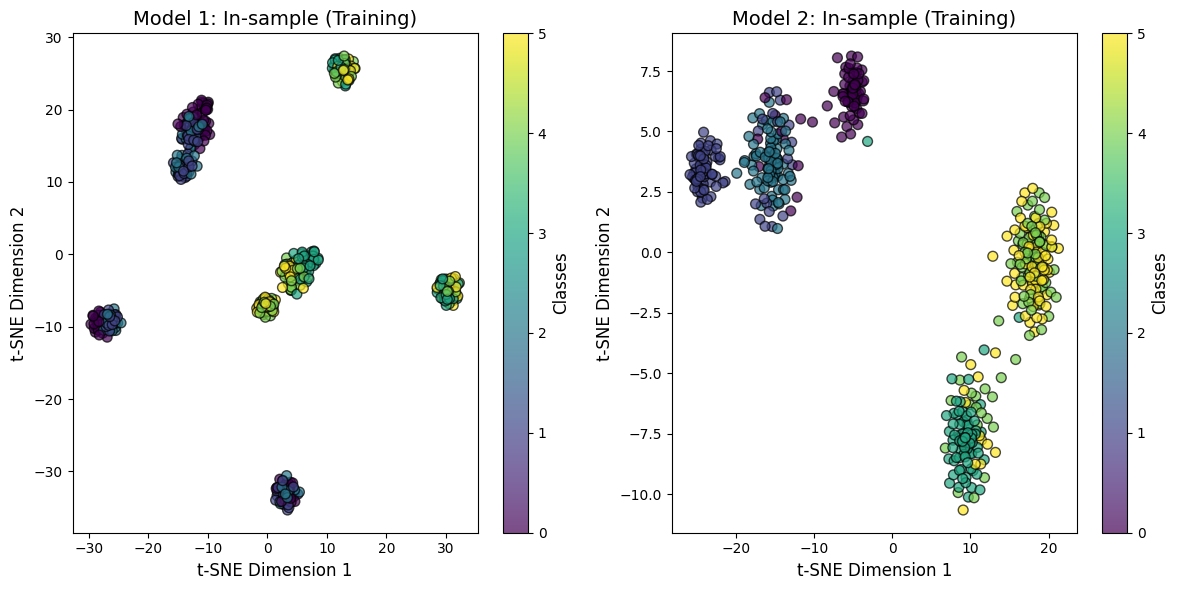

In [10]:
viz_tsne(models, task="train")

### Pourquoi l'entraînement devient mauvais avec la distance cosinus ?

Lorsque l'on entraîne un modèle avec la **distance cosinus** au lieu de la **distance euclidienne**, plusieurs problèmes peuvent survenir :

1. **Perte d'information sur les normes** :  
   - La distance cosinus ignore la norme des embeddings. Cela empêche le modèle d'utiliser pleinement l'information contenue dans l'amplitude des vecteurs, ce qui peut être crucial pour distinguer certaines classes.

2. **Gradients moins informatifs** :  
   - La distance cosinus structure l'espace en fonction des **angles entre vecteurs**. Cela peut rendre les gradients moins clairs ou plus faibles, compliquant l'apprentissage des prototypes par le modèle.

3. **Instabilité sans normalisation explicite** :  
   - La distance cosinus suppose que les vecteurs sont **normalisés** (via L2). Si les embeddings ne sont pas explicitement normalisés, cela introduit de l'instabilité et empêche le modèle de converger correctement.

## 4. **Matching Networks**

L'idée principale des **Matching Networks** est d'apprendre à classer un exemple non vu en se basant sur sa similarité avec un ensemble de support $S$, composé d'exemples étiquetés. Cela s'inspire des méthodes par mémoire et par voisinage.

#### *Principe*

Étant donné un ensemble de support $S = \{(x_1, y_1), \dots, (x_N, y_N)\}$ et une instance de requête $x_q$, l'objectif est de prédire la probabilité $\mathbb{P}(y_q | x_q, S)$ en calculant une pondération sur les labels des exemples du support.

Formellement, le classificateur est défini comme :
$$
P(y_q = k | x_q, S) = \sum_{i=1}^N a(x_q, x_i) \cdot \mathbb{1}(y_i = k)
$$
où :
- $a(x_q, x_i)$ est une fonction d'attention ou de similarité entre l'exemple de requête $x_q$ et $x_i$ (par exemple, le **cosinus de similarité** ou une distance basée sur un réseau).

#### *Fonction d'attention*

La fonction d'attention est calculée comme :
$$
a(x_q, x_i) = \frac{\exp(-d(f(x_q), f(x_i)))}{\sum_{j=1}^N \exp(-d(f(x_q), f(x_j)))}
$$
où :
- $f(x)$ est une fonction d'encodage (souvent un réseau de neurones) qui transforme $x$ en un espace de représentation.
- $d(\cdot, \cdot)$ est une mesure de distance (par exemple, la distance euclidienne).

Le modèle repose principalement sur deux réseaux clés :

1. **Le réseau d'encodage (Embedding function) $f$** : Ce réseau est utilisé pour projeter à la fois les exemples du support set (les exemples de référence) et l'exemple de requête dans un espace d'embedding partagé. 

2. **Le réseau de similarité (Attention kernel) $a$** : Une fois que tous les points (du support set et de la requête) sont projetés dans l'espace d'embedding, un mécanisme de similarité pondérée est utilisé pour comparer la requête à chaque élément du support set. Cela est généralement fait avec une fonction de kernel comme le *cosine similarity* ou une autre mesure définie.

----

L'architecture repose sur un réseau d'embedding qui encode les données d'entrée dans un espace vectoriel dense et significatif.

- **Embedding (CNN)** :
  - 4 couches convolutives séquentielles avec :
    - Convolution 1D
    - Batch Normalization
    - Activation ReLU
    - MaxPooling (réduction de la taille spatiale)
  - La sortie finale est aplatie pour produire un vecteur d'embedding pour chaque signal.

- **Enrichissement de l'embedding**: Un *Bidirectional LSTM* peut être utilisé pour enrichir les embeddings avec le contexte global de la séquence.

- **Distance**: ce module calcule les **similarités cosinus** entre les embeddings du support set et l'embedding de la requête cible (target signal).

- **Attentional Classifier**: Ce module utilise une combinaison d'attention pour pondérer les similarités et prédire la probabilité des classes. Plus précisément, il prend les similarités cosinus et les étiquettes one-hot du support set, applique un softmax sur les similarités pour produire des pondérations et combine les pondérations avec les étiquettes du support set pour prédire la classe cible.

- **Matching Network**: combine tous les composants précédents pour réaliser le **few-shot learning** :
1. Encode le **support set** et le **signal cible** avec le **Classifier**.
2. Si activé, passe les embeddings du support set dans le **Bidirectional LSTM**.
3. Calcule les **similarités cosinus** avec le **Distance Network**.
4. Utilise le **Attentional Classifier** pour prédire la classe du signal cible.
- Apprentissage :
  - **Loss** : Cross-Entropy Loss entre les prédictions et les vraies étiquettes.
  - **Accuracy** : Pourcentage de bonnes prédictions.

In [16]:
# TODO peut etre présenté brievement? (dans tout les cas il l'a fait en cours)

# Regarder si on peut entrainer un modele legeremment plus gros et si on aura de meilleurs resultats

# Comparer brièvement (TEMPS DE CALCUL !!!!)

In [34]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 3,  # Number of epochs for training
    'learning_rate': 0.01,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 1, # % of data of the train set used for training
    'matching': 1,
    'channels':2,
    'total_train_batches':100,
    'batch_size':32,
    'fce':0,
    'classes_per_set':6,
    'samples_per_class':20,
}

In [35]:
from src.train_matching import main_matching

In [ ]:
out = main_matching(opt)

In [39]:
model = MatchingNetwork(batch_size=opt['batch_size'],
                        num_channels=opt['channels'],
                        fce=opt['fce'],
                        num_classes_per_set=opt['classes_per_set'],
                        num_samples_per_class=opt['samples_per_class'])

# ntbk/best_matching_net_spc10.pth
# logs/best_matching_net_spc10.pth
state_dict_path = '../logs/last_matching_net_spc5.pth'
state_dict = torch.load(state_dict_path, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict)

/tmp/ipykernel_1933/1465661080.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location=torch.device('cuda:0'))


<All keys matched successfully>

In [40]:
from src.train_matching import matching_n_shot

In [41]:
acc = matching_n_shot(model, n=5)
print("Accuracy 5 shots", acc)

Accuracy 5 shots 0.33400002121925354


In [42]:
vals = {}
for n in tqdm([1, 2, 5, 10, 20, 50]):
    vals[n] = []
    for _ in range(10):
        vals[n].append(matching_n_shot(model, n=n))


100%|██████████| 6/6 [03:56<00:00, 39.35s/it]


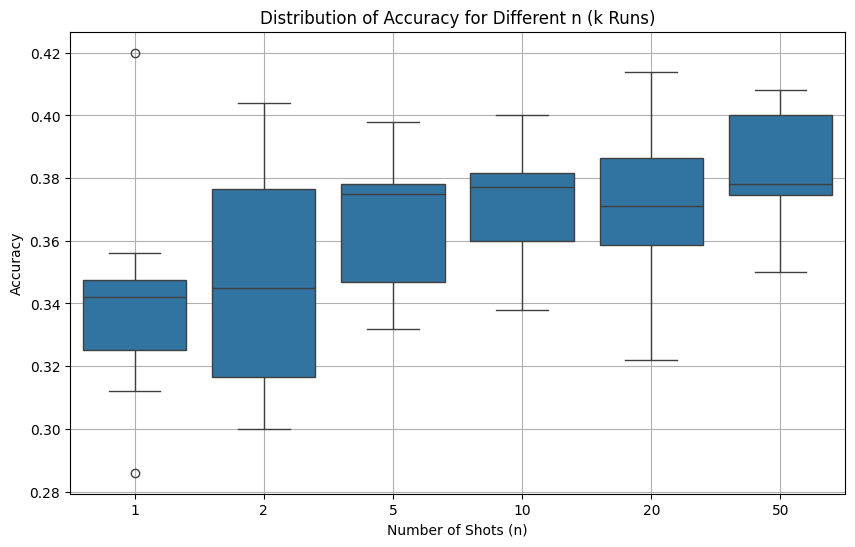

In [43]:
plot_from_list_acc(vals)

## Conclusion

### Prototype
* Présente de bons résultats, qui dépendent cependant grandement de l'entraînement initial du modèle
* Méthode d'application simple et relativement peu gourmande en puissance de calcul
* Performance évoluant rapidement en augmentant $N$ (nombre de données d'enrollement)
* Modèle qui apprend à différentier et a projeter

### Matching Network
* Beaucoup plus gourmand en terme de puissance de calcul
* Résultats moins dépendants du nombre de données d'enrollements $N$
* Résultats moins impressionnants, plusieurs améliorations possible (entraînement, taille du réseau etc...) mais puissance de calcul limitée (GPU!!)
* Modèle qui apprend à comparer efficacement

## Comparaison aux papiers

Les papiers étudiés présentaient des résultats très élevés pour la tâche de Few Shot Learning (proche de 90% d'accuracy). Cependant, une différence fondamentale entre notre expérience et les résultats des papiers originaux sont les types des données

En effet les auteurs appliquent le modèle sur des images (tandis que nous disposons de signaux), une explication possible pour nos performances peut être que l'apprentissage pour nos signaux se généralisent moins par rapport à l'apprentissage sur des images.

![test](../fig/omniglot_grid.jpg)

Généralement, les méthodes de transfer learning sont très efficace en traitement du langage ou en computer vision car les modèles apprennent généralement des connaissances générales sur les données. Cependant, le transfer learning est moins développé en traitement des signaux car les séries temporelles ont généralement des caractéristiques très spécifiques qu'on ne peut pas ou peu retrouvé sur d'autres données. Par exemple, l'état de l'art en détection d'anomalie (PaDIM, PatchCore etc...) utilisent des méthodes de transfer learning pour la détection d'anomalie en raison de la capacité des modèles d'apprendre des connaissances générales sur les images, tandis que en détection d'anomalie pour les signaux, peu de méthode de transfer learning ont été explorées.